
## Pitch Modeling


Goals for a new approach to pitch modeling:

- Improve the target variable. Most stuff models use target metrics like context-neutral re24/re288 run values, context-specific run values like delta_run_exp, or called/swinging strike rate (CSW%). My approach will use expected run value as seen in expected wOBA, which uses exit velocity and launch angle to predict wOBA. I won't be using wOBA as a base metric due to reasons I've discussed [here](https://sam-walsh.github.io/posts/double-plays/) and [here](https://sam-walsh.github.io/posts/fixing-xwoba/). Instead I will be predicting  run values for balls in play based on exit velocity, launch angle, and batter handedness normalized spray angle bins to reduce the noise of the target metric, while still taking into account context-specific outcomes like double plays and sacrifice flies.

- Improve location modeling. Scott Powers, former Dodgers Analyst, and Professor of Sports Analytics and his student Vicente Iglesias recently gave a presentation at Saberseminar about improving location modeling using bayesian hierarchical models. More about that [here](https://github.com/saberpowers/predictive-pitch-score/blob/main/documentation/2023-08-12_saberseminar/slides.pdf). I will be taking a similar approach which will help improve location modeling, especially in small sample sizes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
import xgboost as xgb
import joblib

In [2]:
# load in data with predicted run values
df = pd.read_csv('statcast_data/df_all_spin.csv')

In [3]:
## Calculate vertical approach angle and horizontal approach angle (degrees) for each pitch
df['vaa'] = np.arctan((df['plate_z'] - df['release_pos_z']) / (df['release_pos_y'])) * (180 / np.pi)
df['haa'] = np.arctan((df['plate_x'] - df['release_pos_x']) / (df['release_pos_y'])) * (180 / np.pi)

df['axis_deviation_adj'] = np.where(df['p_throws']=='L', df['diff_measured_inferred'].mul(-1), df['diff_measured_inferred'])

In [4]:
df.loc[df['p_throws']=='R'].groupby('pitch_type')[['vaa', 'haa']].mean()

,vaa,haa
pitch_type,,
CH,-4.156392,1.638207
CS,-4.237966,1.667911
CU,-4.345295,1.946825
EP,-3.541607,1.428788
FA,-3.573859,1.785931
FC,-3.759505,2.317189
FF,-3.256688,1.919538
FO,-5.085853,1.909982
FS,-4.433071,1.591270


In [5]:
df.pitch_type.unique()

array(['FF', 'SL', 'SI', 'FC', 'CU', 'CH', 'KC', 'CS', 'FS', 'ST', 'SV',
       'EP', 'FA', nan, 'KN', 'PO', 'SC', 'FO'], dtype=object)

Group pitch types

In [6]:
fastballs = ['FF', 'SI', 'FC']
non_fastballs = ['CH', 'FS', 'FO', 'KC', 'CU', 'SL', 'ST', 'SV', 'CS', 'SC']

Train on 2020-2022 data, use 2023 as holdout set

In [7]:
df_fastballs = df.loc[(df['pitch_type'].isin(fastballs)) & (df['game_year'].isin([2020, 2021, 2022]))]
df_fastballs_holdout = df.loc[(df['pitch_type'].isin(fastballs)) & (df['game_year']==2023)]

In [8]:
df_fastballs.head()

,Unnamed: 0.1,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,predicted_run_value,player_id,api_pitch_type,active_spin_formatted,hawkeye_measured,movement_inferred,diff_measured_inferred,vaa,haa,axis_deviation_adj
0,0,2875.0,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,...,0.015513,543272.0,FF,89.0,129.2,139.2,-10.0,-3.002928,-2.721848,10.0
6,6,3604.0,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,...,-0.240455,543272.0,FF,89.0,129.2,139.2,-10.0,-3.475779,-2.956457,10.0
10,10,2843.0,SI,2020-09-27,96.7,-2.20,5.92,"Cederlind, Blake",596019,664977,...,-0.192297,NaN,NaN,NaN,NaN,NaN,NaN,-4.351309,2.456165,NaN
11,11,2951.0,SI,2020-09-27,97.1,-2.20,5.99,"Cederlind, Blake",596019,664977,...,-0.060000,NaN,NaN,NaN,NaN,NaN,NaN,-3.498537,2.966262,NaN
12,12,3160.0,SI,2020-09-27,97.3,-2.34,5.94,"Cederlind, Blake",596019,664977,...,0.060000,NaN,NaN,NaN,NaN,NaN,NaN,-3.579655,3.569029,NaN


In [9]:
fastball_features = [
    'release_speed', 'az', 'ax', 'active_spin_formatted',
    'plate_x', 'plate_z', 'axis_deviation_adj', 'vaa',
    'haa'
]
target = 'predicted_run_value'

In [10]:
df_fastballs[fastball_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 961780 entries, 0 to 1717441
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   release_speed          961752 non-null  float64
 1   az                     961766 non-null  float64
 2   ax                     961766 non-null  float64
 3   active_spin_formatted  941022 non-null  float64
 4   plate_x                961766 non-null  float64
 5   plate_z                961766 non-null  float64
 6   axis_deviation_adj     941022 non-null  float64
 7   vaa                    961622 non-null  float64
 8   haa                    961622 non-null  float64
dtypes: float64(9)
memory usage: 73.4 MB


In [11]:
df_fastballs[target].info()

<class 'pandas.core.series.Series'>
Index: 961780 entries, 0 to 1717441
Series name: predicted_run_value
Non-Null Count   Dtype  
--------------   -----  
961780 non-null  float64
dtypes: float64(1)
memory usage: 14.7 MB


In [12]:
df_fastballs = df_fastballs.dropna(subset=fastball_features)
df_fastballs = df_fastballs.dropna(subset=[target])

df_fastballs_holdout = df_fastballs_holdout.dropna(subset=fastball_features)
df_fastballs_holdout = df_fastballs_holdout.dropna(subset=[target])

In [13]:
df_fastballs.head()

,Unnamed: 0.1,Unnamed: 0,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,predicted_run_value,player_id,api_pitch_type,active_spin_formatted,hawkeye_measured,movement_inferred,diff_measured_inferred,vaa,haa,axis_deviation_adj
0,0,2875.0,FF,2020-09-27,91.6,2.31,6.19,"Hand, Brad",605137,543272,...,0.015513,543272.0,FF,89.0,129.2,139.2,-10.0,-3.002928,-2.721848,10.0
6,6,3604.0,FF,2020-09-27,92.8,2.39,6.27,"Hand, Brad",663647,543272,...,-0.240455,543272.0,FF,89.0,129.2,139.2,-10.0,-3.475779,-2.956457,10.0
23,23,4283.0,FF,2020-09-27,91.3,2.59,5.99,"Hand, Brad",624428,543272,...,0.243738,543272.0,FF,89.0,129.2,139.2,-10.0,-4.009259,-3.386027,10.0
24,24,4455.0,FF,2020-09-27,92.5,2.43,6.14,"Hand, Brad",624428,543272,...,0.060000,543272.0,FF,89.0,129.2,139.2,-10.0,-3.643167,-3.466656,10.0
25,25,4472.0,FF,2020-09-27,90.5,2.52,6.02,"Hand, Brad",624428,543272,...,-0.060000,543272.0,FF,89.0,129.2,139.2,-10.0,-4.321128,-3.717588,10.0


In [14]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10)

# Get the indices for the training and validation sets
train_idx, val_idx = next(gss.split(df_fastballs, groups=df_fastballs['pitcher']))

# Create the training and validation sets
train = df_fastballs.iloc[train_idx]
val = df_fastballs.iloc[val_idx]

In [15]:
# # Define the objective function for Optuna
# def objective(trial: Trial) -> float:
#     params = {
#         'device': 'cuda',  # Use GPU acceleration
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0)
#     }

#     model = xgb.XGBRegressor(**params)
#     model.fit(train[fastball_features], train[target])

#     val_preds = model.predict(val[fastball_features])
#     val_error = np.sqrt(((val_preds - val[target]) ** 2).mean())

#     return val_error

# # Run the Optuna optimization
# study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# # Print the best parameters
# print(study.best_params)


In [16]:
# params = study.best_params
# params['device'] = 'cuda'
# xgb_fastball = xgb.XGBRegressor(**params)
# xgb_fastball.fit(df_fastballs[fastball_features], df_fastballs[target])

In [17]:
# xgb_fastball.save_model('models/xgb_fastball.json')

In [18]:
xgb_fastball = xgb.XGBRegressor()
xgb_fastball.load_model('models/xgb_fastball.json')

In [19]:
df_fastballs_holdout['xgb_preds'] = xgb_fastball.predict(df_fastballs_holdout[fastball_features])

#### Breaking ball / off-speed feature engineering
Calculating some fastball-relative features 

In [27]:
from feature_engineering import compute_fastball_relative_features
df = compute_fastball_relative_features(df)

In [28]:
non_fastball_features = [
    'release_speed', 'release_spin_rate', 'az', 'ax', 'plate_x', 'plate_z',
    'axis_deviation_adj', 'velo_delta', 'spin_axis_delta',
    'vert_delta', 'horz_delta', 'vaa', 'haa'
]
target = 'predicted_run_value'

In [29]:
df_non_fastballs = df.loc[df['pitch_type'].isin(non_fastballs) & (df['game_year'].isin([2020, 2021, 2022]))]
df_non_fastballs_holdout = df.loc[df['pitch_type'].isin(non_fastballs) & (df['game_year']==2023)]

In [30]:
df_non_fastballs[non_fastball_features].info()

<class 'pandas.core.frame.DataFrame'>
Index: 727319 entries, 1 to 1717442
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   release_speed       727286 non-null  float64
 1   release_spin_rate   723866 non-null  float64
 2   az                  727293 non-null  float64
 3   ax                  727293 non-null  float64
 4   plate_x             727293 non-null  float64
 5   plate_z             727293 non-null  float64
 6   axis_deviation_adj  706657 non-null  float64
 7   velo_delta          713897 non-null  float64
 8   spin_axis_delta     706657 non-null  float64
 9   vert_delta          713903 non-null  float64
 10  horz_delta          713903 non-null  float64
 11  vaa                 727227 non-null  float64
 12  haa                 727227 non-null  float64
dtypes: float64(13)
memory usage: 77.7 MB


In [31]:
df_non_fastballs = df_non_fastballs.dropna(subset=non_fastball_features)
df_non_fastballs = df_non_fastballs.dropna(subset=[target])

df_non_fastballs_holdout = df_non_fastballs_holdout.dropna(subset=non_fastball_features)
df_non_fastballs_holdout = df_non_fastballs_holdout.dropna(subset=[target])

In [32]:
# Create a GroupShuffleSplit to keep pitchers in the same training or validation set
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10)

# Get the indices for the training and validation sets
train_idx, val_idx = next(gss.split(df_non_fastballs, groups=df_non_fastballs['pitcher']))

# Create the training and validation sets
train = df_non_fastballs.iloc[train_idx]
val = df_non_fastballs.iloc[val_idx]

Train and tune non-fastball model

In [33]:
# # Define the objective function for Optuna
# def objective(trial: Trial) -> float:
#     params = {
#         'device': 'cuda',  # Use GPU acceleration
#         'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0)
#     }

#     model = xgb.XGBRegressor(**params)
#     model.fit(train[non_fastball_features], train[target])

#     val_preds = model.predict(val[non_fastball_features])
#     val_error = np.sqrt(((val_preds - val[target]) ** 2).mean())

#     return val_error

# # Run the Optuna optimization
# study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# # Print the best parameters
# params = study.best_params
# params['device'] = 'cuda'

# xgb_non_fastball = xgb.XGBRegressor(**params)
# xgb_non_fastball.fit(df_non_fastballs[non_fastball_features], df_non_fastballs[target])


In [34]:
# xgb_non_fastball.save_model('models/xgb_non_fastball.json')

In [35]:
xgb_non_fastball = xgb.XGBRegressor()
xgb_non_fastball.load_model('models/xgb_non_fastball.json')

In [117]:
df_non_fastballs_holdout.loc[:, 'xgb_preds'] = xgb_non_fastball.predict(df_non_fastballs_holdout.loc[:, non_fastball_features])

Generate percentile rankings for fastballs

In [174]:
df_holdout = pd.concat([df_fastballs_holdout, df_non_fastballs_holdout])

In [164]:
df2 = df_holdout.groupby(['player_name', 'pitcher', 'pitch_type'], as_index=False)[['predicted_run_value', 'xgb_preds', 'release_speed']] \
    .agg({'xgb_preds':['mean', 'sum'], 'release_speed':'count', 'predicted_run_value':'sum'}) \
    .reset_index(drop=True) \
    .rename(columns={'release_speed':'pitches_thrown', 'predicted_run_value': 'expected_runs_saved'})

# Flatten the multi-index in columns
df2.columns = ['_'.join(col).rstrip('_') if isinstance(col, tuple) else col for col in df2.columns.values]

# Rename the columns
df2 = df2.rename(columns={
    'xgb_preds_mean': 'average_pitch_score',
    'xgb_preds_sum': 'total_pitch_score',
    'pitches_thrown_count': 'pitches_thrown',
    'expected_runs_saved_sum': 'expected_runs_saved'})

df2['average_pitch_score'] = df2['average_pitch_score'].mul(-1)
df2['total_pitch_score'] = df2['total_pitch_score'].mul(-1)
df2['expected_runs_saved'] = df2['expected_runs_saved'].mul(-1)
df2 = df2.round(4)


In [166]:
df2['expected_runs_percentile'] = df2['expected_runs_saved'].rank(pct=True).round(2).mul(100)
df2['pitch_score_percentile'] = df2['average_pitch_score'].rank(pct=True).round(2).mul(100)
df2.query('pitches_thrown > 100').sort_values('average_pitch_score', ascending=False).head(50)


,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
446,"Graterol, Brusdar",660813,SI,0.0150,5.743000,383,7.1753,99.0,100.0
979,"Rasmussen, Drew",656876,FF,0.0148,2.941300,199,1.1901,81.0,100.0
1237,"Vesia, Alex",681911,FF,0.0132,6.975100,528,4.6712,96.0,99.0
83,"Bautista, Félix",642585,FF,0.0128,8.943000,696,12.9818,100.0,99.0
1148,"Strider, Spencer",675911,FF,0.0124,20.453199,1653,6.9514,98.0,99.0
1136,"Stewart, Brock",592779,FF,0.0124,1.876800,151,2.5063,90.0,99.0
337,"Estrada, Jeremiah",669093,FF,0.0122,2.437200,199,-4.5303,12.0,99.0
493,"Helsley, Ryan",664854,FF,0.0121,3.571900,294,5.1902,97.0,99.0
465,"Hader, Josh",623352,SI,0.0100,6.844600,686,9.9277,99.0,98.0
18,"Alcantara, Sandy",645261,SI,0.0100,7.884500,790,-1.3658,39.0,98.0


In [167]:
df2.loc[df2['player_name']=='Harrison, Kyle']


,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
477,"Harrison, Kyle",690986,FF,-0.0049,-1.3181,267,0.1403,64.0,39.0


[22:36:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[22:36:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


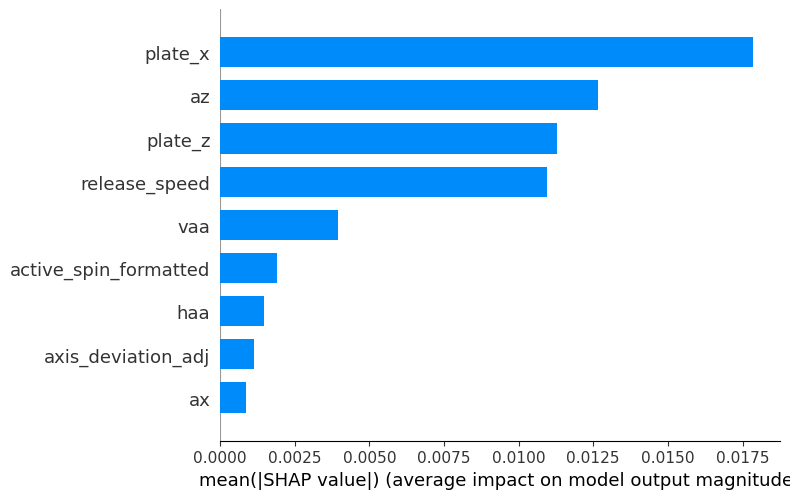

In [23]:
import shap

def plot_shap_values(df, model, features, pitch_type, pitcher=None):
    # Filter the data for the specified pitch type
    df_filtered = df[df['pitch_type'] == pitch_type]
    if pitcher:
        df_filtered = df_filtered[df_filtered['pitcher'] == pitcher]
    # Create the explainer
    explainer = shap.Explainer(model)

    # Calculate the shap values
    shap_values = explainer.shap_values(df_filtered[features])

    # Plot the shap values
    shap.summary_plot(shap_values, df_filtered[features], plot_type="bar")

plot_shap_values(df_fastballs, xgb_fastball, fastball_features, 'SI', 643511)

In [168]:
def top_pitches(df, pitch_types, min_pitches=100, top_n=50):
    """
    Returns the top n pitches in pitch_score_percentile for a selected pitch type(s) 
    with an option to filter number of pitches_thrown.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the pitch data.
    pitch_types (list): List of pitch types to consider.
    min_pitches (int): Minimum number of pitches thrown to consider.
    top_n (int): Number of top pitches to return.

    Returns:
    pandas.DataFrame: DataFrame containing the top n pitches.
    """
    if isinstance(pitch_types, str):
        pitch_types = [pitch_types]

    return (df.loc[df['pitch_type'].isin(pitch_types)]
              .query('pitches_thrown > @min_pitches')
              .sort_values('pitch_score_percentile', ascending=False)
              .head(top_n))

Top 50 four-seam fastballs

In [170]:
top_fastballs = top_pitches(df2, 'FF')
top_fastballs

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
979,"Rasmussen, Drew",656876,FF,0.0148,2.941300,199,1.1901,81.0,100.0
337,"Estrada, Jeremiah",669093,FF,0.0122,2.437200,199,-4.5303,12.0,99.0
1237,"Vesia, Alex",681911,FF,0.0132,6.975100,528,4.6712,96.0,99.0
493,"Helsley, Ryan",664854,FF,0.0121,3.571900,294,5.1902,97.0,99.0
83,"Bautista, Félix",642585,FF,0.0128,8.943000,696,12.9818,100.0,99.0
1136,"Stewart, Brock",592779,FF,0.0124,1.876800,151,2.5063,90.0,99.0
1148,"Strider, Spencer",675911,FF,0.0124,20.453199,1653,6.9514,98.0,99.0
791,"Megill, Trevor",656730,FF,0.0100,3.613100,363,2.7395,91.0,98.0
954,"Pérez, Eury",691587,FF,0.0095,6.202700,655,-5.7472,9.0,98.0
1296,"Wheeler, Zack",554430,FF,0.0096,11.679800,1223,20.9691,100.0,98.0


Top 20 cutters

In [171]:
top_pitches(df2, 'FC', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
978,"Rasmussen, Drew",656876,FC,0.0099,2.3943,242,4.3146,95.0,98.0
221,"Clase, Emmanuel",661403,FC,0.0098,6.9622,709,10.1646,99.0,98.0
814,"Minter, A.J.",621345,FC,0.0092,3.4718,377,2.1329,88.0,97.0
1265,"Walter, Brandon",687888,FC,0.0082,0.9373,114,0.7457,75.0,97.0
568,"Jansen, Kenley",445276,FC,0.0080,4.5579,568,5.6042,97.0,96.0
1293,"Wesneski, Hayden",669713,FC,0.0079,1.1195,141,-3.2366,20.0,96.0
864,"Nelson, Ryne",669194,FC,0.0074,2.4396,330,-3.0484,21.0,95.0
453,"Gray, Sonny",543243,FC,0.0073,2.5797,355,0.4550,71.0,95.0
370,"France, J.P.",641585,FC,0.0074,2.9844,402,1.8536,86.0,95.0
752,"Martin, Chris",455119,FC,0.0067,1.6069,241,2.1160,87.0,94.0


Top 20 sinkers

In [172]:
top_pitches(df2, 'SI', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
446,"Graterol, Brusdar",660813,SI,0.0150,5.7430,383,7.1753,99.0,100.0
28,"Almonte, Yency",622075,SI,0.0097,2.0518,212,1.2473,82.0,98.0
465,"Hader, Josh",623352,SI,0.0100,6.8446,686,9.9277,99.0,98.0
767,"May, Dustin",669160,SI,0.0095,2.3370,245,3.3058,93.0,98.0
18,"Alcantara, Sandy",645261,SI,0.0100,7.8845,790,-1.3658,39.0,98.0
1204,"Topa, Justin",623437,SI,0.0097,4.0874,422,4.8487,96.0,98.0
1016,"Rogers, Tyler",643511,SI,0.0086,4.5092,523,6.2573,98.0,97.0
754,"Martin, Chris",455119,SI,0.0093,0.9754,105,2.2641,88.0,97.0
1021,"Romero, JoJo",668941,SI,0.0086,1.5828,184,2.2563,88.0,97.0
706,"Loáisiga, Jonathan",642528,SI,0.0088,1.4495,165,3.0109,92.0,97.0


Top changeups

In [149]:
top_pitches(df2, 'CH', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
986,"Montero, Rafael",606160,CH,0.0167,4.1702,249,-0.2928,48.0,99.0
1551,"Williams, Devin",642207,CH,0.0167,8.4689,507,8.9589,99.0,99.0
1327,"Snell, Blake",605483,CH,0.0140,7.5670,540,13.2747,100.0,98.0
163,"Brazoban, Huascar",623211,CH,0.0139,3.7659,271,6.3728,97.0,98.0
1098,"Pepiot, Ryan",686752,CH,0.0143,1.9815,139,1.2147,78.0,98.0
27,"Alcantara, Sandy",645261,CH,0.0138,10.2669,742,6.7204,97.0,98.0
716,"Kelly, Merrill",518876,CH,0.0132,7.7336,588,7.5378,98.0,97.0
1106,"Peralta, Wandy",593974,CH,0.0122,4.7633,390,0.4329,68.0,96.0
457,"Gallen, Zac",668678,CH,0.0108,4.3879,408,-0.0519,55.0,95.0
220,"Castillo, Luis",622491,CH,0.0089,4.0570,455,-2.6160,14.0,91.0


Top curveballs

In [151]:
top_pitches(df2, 'CU', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
598,"Herget, Jimmy",623474,CU,0.0097,1.5128,156,0.7397,73.0,93.0
369,"Duran, Jhoan",661395,CU,0.0088,2.2688,259,0.3992,67.0,91.0
684,"Johnson, Pierce",572955,CU,0.0088,5.2083,591,6.4522,97.0,91.0
1230,"Ryu, Hyun Jin",547943,CU,0.0085,0.9140,108,3.6716,92.0,90.0
734,"Kikuchi, Yusei",579328,CU,0.0084,3.9442,472,-0.5896,42.0,89.0
961,"Miller, Bobby",676272,CU,0.0075,2.3668,317,0.0461,58.0,87.0
1609,"Zastryzny, Rob",642239,CU,0.0072,0.7538,105,1.8884,84.0,86.0
923,"McClanahan, Shane",663556,CU,0.0072,2.2351,309,-1.5731,25.0,86.0
744,"Kirby, George",669923,CU,0.0070,2.2052,314,2.3551,86.0,85.0
1130,"Pressly, Ryan",519151,CU,0.0068,1.5568,229,1.4485,81.0,84.0


Top splitters

In [153]:
top_pitches(df2, 'FS', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
572,"Harvey, Hunter",640451,FS,0.0176,2.8706,163,0.0951,59.0,100.0
416,"Finnegan, Kyle",640448,FS,0.0126,3.2523,259,3.4957,92.0,97.0
370,"Duran, Jhoan",661395,FS,0.0128,3.3113,258,5.1977,95.0,97.0
1576,"Winn, Keaton",676775,FS,0.0092,2.6400,286,2.7911,89.0,91.0
101,"Bednar, David",670280,FS,0.0087,1.4481,167,0.7916,74.0,90.0
563,"Harris, Hobie",665048,FS,0.0085,1.4866,175,-1.4280,27.0,90.0
385,"Eovaldi, Nathan",543135,FS,0.0084,4.5058,536,7.1355,98.0,89.0
870,"Maeda, Kenta",628317,FS,0.0072,3.5182,489,2.6473,88.0,86.0
93,"Bautista, Félix",642585,FS,0.0050,1.2128,242,5.1795,95.0,76.0
256,"Cobb, Alex",502171,FS,0.0046,4.3278,944,-10.3571,0.0,74.0


In [154]:
top_pitches(df2, 'SL', top_n=20)

,player_name,pitcher,pitch_type,average_pitch_score,total_pitch_score,pitches_thrown,expected_runs_saved,expected_runs_percentile,pitch_score_percentile
1617,"deGrom, Jacob",594798,SL,0.0234,3.9103,167,2.6151,88.0,100.0
251,"Clase, Emmanuel",661403,SL,0.0179,5.9186,330,4.1712,93.0,100.0
1251,"Santos, Gregory",666619,SL,0.0184,10.1131,551,13.8501,100.0,100.0
1303,"Sims, Lucas",608371,SL,0.0172,8.5860,500,7.1184,97.0,99.0
587,"Helsley, Ryan",664854,SL,0.0156,2.7304,175,6.3115,96.0,99.0
1131,"Pressly, Ryan",519151,SL,0.0171,6.4662,379,8.3500,98.0,99.0
962,"Miller, Bobby",676272,SL,0.0174,5.2094,299,-4.1218,6.0,99.0
1160,"Ragans, Cole",666142,SL,0.0146,2.1298,146,3.3562,91.0,98.0
247,"Civale, Aaron",650644,SL,0.0137,1.4509,106,-0.3185,48.0,98.0
1592,"Woodruff, Brandon",605540,SL,0.0145,1.3624,94,-0.1351,53.0,98.0


In [49]:
df_holdout.to_csv('model_predictions.csv')

<Axes: >

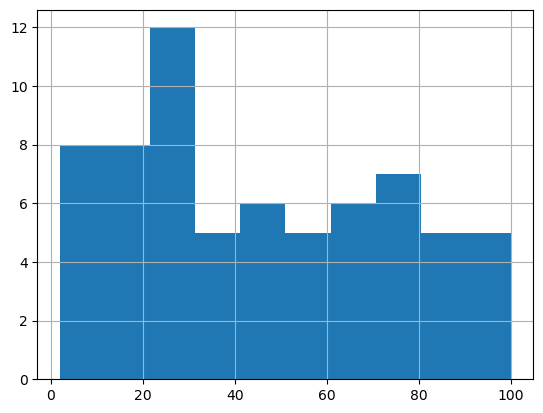